<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/DZ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт всех нужных библиотек:
* pandas для работы с таблицами,
* numpy — для чисел,
* matplotlib и seaborn — для графиков.
* scikit-learn — для моделей и оценки,
* TensorFlow — для нейронки.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import models, layers

Загружаем обучающую и тестовую выборки, а также пример отправки

In [42]:
train = pd.read_csv("fmnist_train.csv")
test = pd.read_csv("fmnist_test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

Проверка: сколько строк и столбцов, и есть ли пропуски. Это нужно, чтобы понять, **надо ли что-то чистить.**

In [43]:
print(train.shape)
print(test.shape)
print(train.head())

print("Проверка на пропуски:")
print(train.isnull().sum().sum(), "в обучении")
print(test.isnull().sum().sum(), "в тесте")

(17040, 786)
(10000, 785)
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2       0  ...       0.0       0.0      30.0      43.0       0.0       0.0   
3       0  ...       0.0       0.0       0.0       0.0       1.0       0.0   
4       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel782  pixel783  pixel784  Id  
0       0.

Визуально смотрим, как выглядят наши данные, чтобы было чуть понятнее, с чем мы работаем.

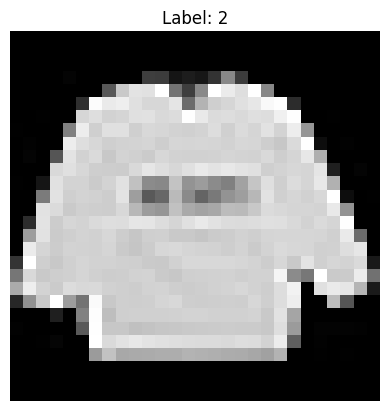

In [44]:
def show_image(index):
    img = train.iloc[index, 1:-1].values.reshape(28, 28)
    label = train.iloc[index, 0]
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

show_image(0)

Заполняем пропуски нулями — простое решение, чтобы модель не падала.

Разделяем:
* X — это признаки (все пиксели),
* y — это правильный ответ (метка класса).

Из test сразу выбрасываем id, он не нужен для предсказаний.


In [45]:
train = train.fillna(0)
test = test.fillna(0)

X = train.drop(columns=["label", "Id"])
y = train["label"]
X_test = test.drop(columns=["Id"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Проверка на пропуски:")
print(train.isnull().sum().sum(), "в обучении")
print(test.isnull().sum().sum(), "в тесте")

Проверка на пропуски:
0 в обучении
0 в тесте


Стандартизируем данные, чтобы нейронка и логрегрессия лучше обучались.

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

Еще раз делим обучающую выборку на обучающую и валидационную — для оценки логистической регрессии.

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
val_preds = model_lr.predict(X_val)

print("Accuracy на валидации:", accuracy_score(y_val, val_preds))

Accuracy на валидации: 0.8142605633802817


Простая полносвязная нейронка: два слоя с ReLU и финальный softmax для классификации на 10 классов.

Компилируем модель:
* оптимизатор — Adam,
* функция потерь — кросс-энтропия,
* метрика — accuracy.

Обучаем нейронку: 10 эпох, размер пакета 64. validation_split — 10% от тренировочной на валидацию.

In [48]:
model_nn = models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_nn.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

model_nn.fit(X_scaled, y, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9553 - loss: 0.1275 - val_accuracy: 0.8621 - val_loss: 0.4713
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9602 - loss: 0.1115 - val_accuracy: 0.8721 - val_loss: 0.4773
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9730 - loss: 0.0840 - val_accuracy: 0.8762 - val_loss: 0.4847
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9748 - loss: 0.0818 - val_accuracy: 0.8779 - val_loss: 0.5348
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9764 - loss: 0.0726 - val_accuracy: 0.8721 - val_loss: 0.5590
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9776 - loss: 0.0694 - val_accuracy: 0.8727 - val_loss: 0.5693
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9772 - loss: 0.0718 - val_accuracy: 0.8773 - val_loss: 0.5562
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9771 - loss: 0.0686 - val_accuracy: 0

Получаем предсказания с модели и загружаем файл

In [49]:
predictions = model_nn.predict(X_test_scaled)
pred_labels = np.argmax(predictions, axis=1)

submission = sample_submission.copy()
submission["label"] = pred_labels
submission.to_csv("submission.csv", index=False)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


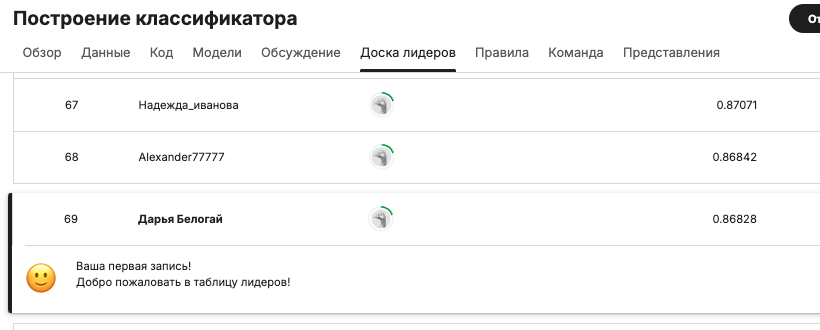